In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy.stats import kstest
from scipy.interpolate import interp1d

In [2]:
def load_fiberstats_by_tracer(tracer='ELG'):
    min_nobs = 50

    cat = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/rongpu/redshift_qa/jura_data/{}.fits'.format(tracer.lower())))


    cat['EFFTIME_BGS'] = 0.1400 * cat['TSNR2_BGS']
    cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

    # Remove FIBERSTATUS!=0 fibers
    mask = cat['COADD_FIBERSTATUS']==0
    print('FIBERSTATUS   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Remove "no data" fibers
    mask = cat['ZWARN'] & 2**9==0
    print('No data   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    # Require a minimum depth for the cat coadd
    if tracer=='BGS_ANY':
        min_depth = 160
        mask = cat['EFFTIME_BGS']>min_depth
    else:
        min_depth = 800.
        mask = cat['EFFTIME_LRG']>min_depth
    print('Min depth   ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
    cat = cat[mask]

    if tracer=='LRG':
        # Apply maskbits
        maskbits = [1, 8, 9, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
    elif tracer=='ELG':
        # Apply maskbits
        maskbits = [1, 11, 12, 13]
        mask = np.ones(len(cat), dtype=bool)
        for bit in maskbits:
            mask &= (cat['MASKBITS'] & 2**bit)==0
        print('MASKBITS  ', np.sum(~mask), np.sum(mask), np.sum(~mask)/len(mask))
        cat = cat[mask]
        
    
    fibers = list(set(cat['FIBER']))

    cat_fibers = {}

    for fiber in fibers:
        ii = cat['FIBER']==fiber
        cat_fibers[fiber] = cat[ii] 
    return cat_fibers

In [3]:
elg_cat_fibers = load_fiberstats_by_tracer(tracer='ELG')
lrg_cat_fibers = load_fiberstats_by_tracer(tracer='LRG')
qso_cat_fibers = load_fiberstats_by_tracer(tracer='QSO')
bgs_cat_fibers = load_fiberstats_by_tracer(tracer='BGS_ANY')

FIBERSTATUS    264198 15709044 0.016540036142944557
No data    0 15709044 0.0
Min depth    587803 15121241 0.037418126780980436
MASKBITS   613801 14507440 0.04059197257685398
FIBERSTATUS    113487 6146815 0.018128039190441612
No data    0 6146815 0.0
Min depth    245309 5901506 0.039908310238717125
MASKBITS   440588 5460918 0.07465687571951973
FIBERSTATUS    100029 5287743 0.018565930406854635
No data    0 5287743 0.0
Min depth    207773 5079970 0.03929332420278368
FIBERSTATUS    245744 13618308 0.01772526531204586
No data    0 13618308 0.0
Min depth    492687 13125621 0.036178282940876355


In [6]:
def ordinal_pattern(values):
    """
    Compute the ordinal pattern of a sequence of values.
    """
    return sorted(range(len(values)), key=lambda k: values[k])

def permutation_entropy(time_series, order= 4, delay= 4):
    """
    Compute the permutation entropy of a 1D time series.

    Parameters:
    - time_series: The input time series (list of float values)
    - order: The order of permutation entropy (default: 4)
    - delay: The delay between values for computing ordinal patterns (default: 4)

    Returns:
    - Permutation entropy value
    """
    n = len(time_series)
    if n < order:
        raise ValueError(f"Time series length ({n}) must be at least as long as the order ({order})")
    
    permutations = {}
    
    for i in range(n - delay * (order - 1)):
        # Extract a subsequence
        pattern = [time_series[i + j * delay] for j in range(order)]
        # Compute its ordinal pattern
        ord_pattern = ordinal_pattern(pattern)
        # Convert to tuple for hashing
        ord_pattern = tuple(ord_pattern)
        
        if ord_pattern in permutations:
            permutations[ord_pattern] += 1
        else:
            permutations[ord_pattern] = 1
    
    # Compute probabilities and entropy
    total = sum(permutations.values())
    entropy = 0
    for count in permutations.values():
        p = count / total
        entropy -= p * np.log2(p)
    
    return entropy

In [8]:
def compute_entropy(cat_fibers):
    print('starting compute entropy ')
    entropies = []
    fibers = []
    lenseries = []
    for i in cat_fibers.keys():
        if len(cat_fibers[i]['Z'])>200:
            f = cat_fibers[i]['Z']
            lenseries.append(len(f))
            fibers.append(i)
            entropy = permutation_entropy(f)
        
            mean_entropy = 0.0
            n_iter = 10
            values = np.zeros(n_iter)
            for j in range(n_iter):
                shuffled_array = np.random.permutation(f)
                values[j] = permutation_entropy(shuffled_array)
            
            entropies.append((entropy - values.mean())/values.std())
        
    entropies = np.array(entropies)
    fibers = np.array(fibers)
    lenseries = np.array(lenseries)
    print('\t finished starting compute entropy ')

    return {'entropy': entropies, 'fibers':fibers, 'lenseries':lenseries}

In [9]:
entropy_bgs = compute_entropy(bgs_cat_fibers)
entropy_lrg = compute_entropy(lrg_cat_fibers)
entropy_elg = compute_entropy(elg_cat_fibers)
entropy_qso = compute_entropy(qso_cat_fibers)

starting compute entropy 
	 finished starting compute entropy 
starting compute entropy 
	 finished starting compute entropy 
starting compute entropy 
	 finished starting compute entropy 
starting compute entropy 
	 finished starting compute entropy 


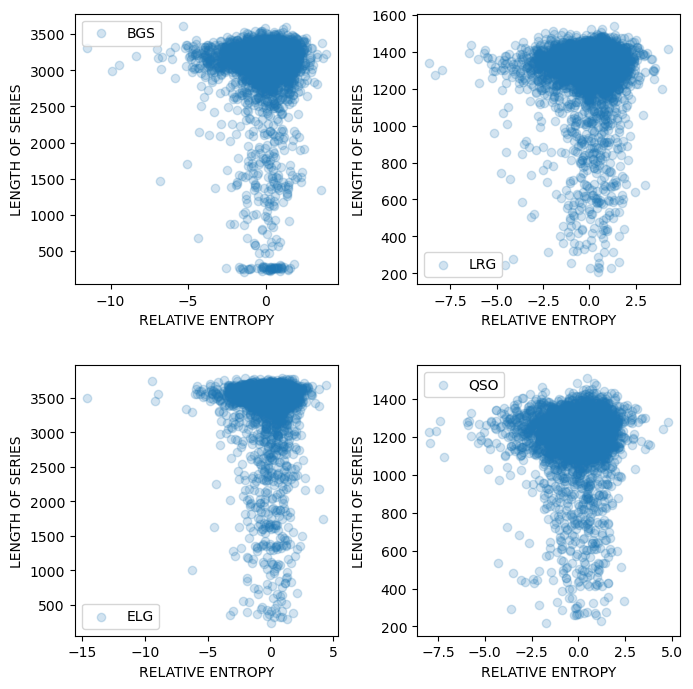

In [27]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot data
data_sets = [entropy_bgs, entropy_lrg, entropy_elg, entropy_qso]
labels = ['BGS', 'LRG', 'ELG', 'QSO']

for i, (data, label) in enumerate(zip(data_sets, labels)):
    axs[i].scatter(data['entropy'], data['lenseries'], label=label, alpha=0.2)
    axs[i].legend()
    axs[i].set_xlabel('RELATIVE ENTROPY')
    axs[i].set_ylabel('LENGTH OF SERIES')

# Adjust the layout
plt.tight_layout()

# Fine-tune spacing
plt.subplots_adjust(wspace=0.3, hspace=0.3)


In [32]:
for i, (data, label) in enumerate(zip(data_sets, labels)):
    ll = data['entropy']<-5
    outlier_fibers = data['fibers'][ll]
    print(f'ENTROPY RESULTS FOR {label}')
    print(f"Number of outliers: {len(outlier_fibers)}")
    print(f"FIBERID of outliers: {outlier_fibers}")
    print('')

ENTROPY RESULTS FOR BGS
Number of outliers: 20
FIBERID of outliers: [ 112  148  557  593  786  850 1033 1306 1428 1666 1786 1818 2481 2620
 2840 3132 3807 4025 4332 4738]

ENTROPY RESULTS FOR LRG
Number of outliers: 18
FIBERID of outliers: [ 459  689 1110 1243 1660 1671 1724 1820 2124 2273 2348 3050 3320 4117
 4272 4344 4458 4471]

ENTROPY RESULTS FOR ELG
Number of outliers: 18
FIBERID of outliers: [ 142  510  579  740 1162 1172 1228 1583 1592 1713 1724 2499 2928 3154
 3648 3735 4624 4640]

ENTROPY RESULTS FOR QSO
Number of outliers: 15
FIBERID of outliers: [  91  338  390  848  988 1499 1976 2057 2081 2578 2751 3059 4059 4396
 4675]



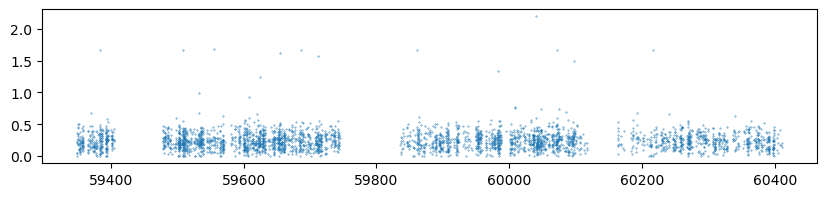

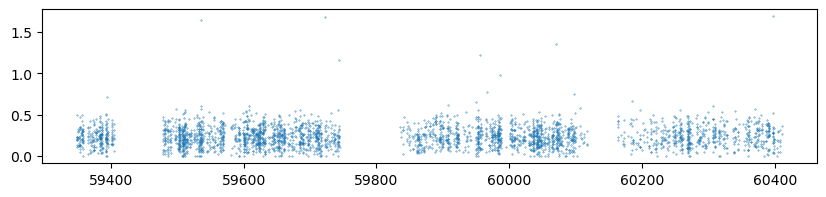

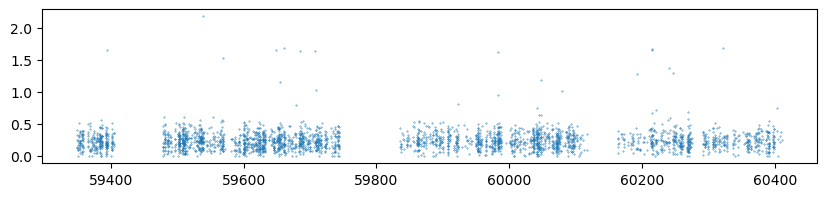

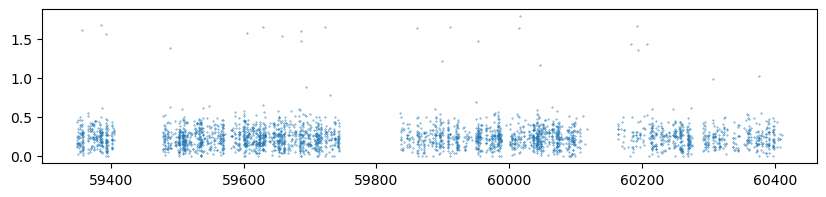

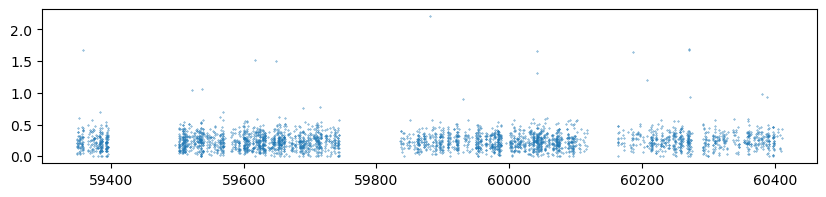

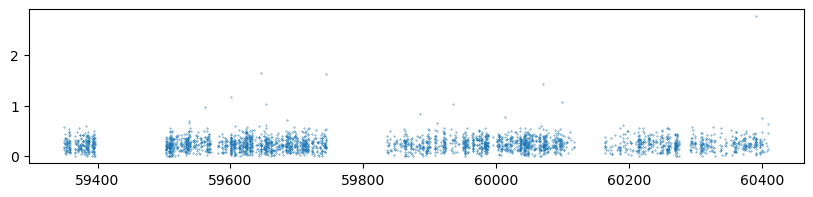

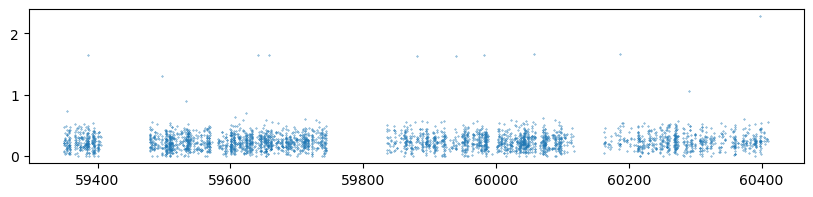

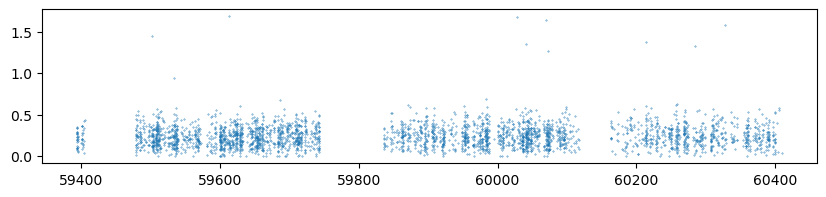

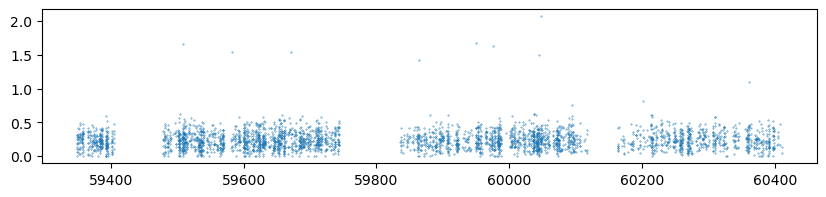

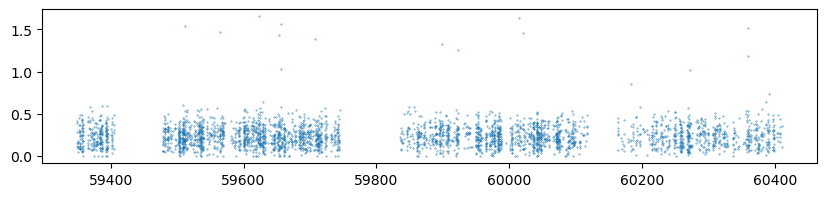

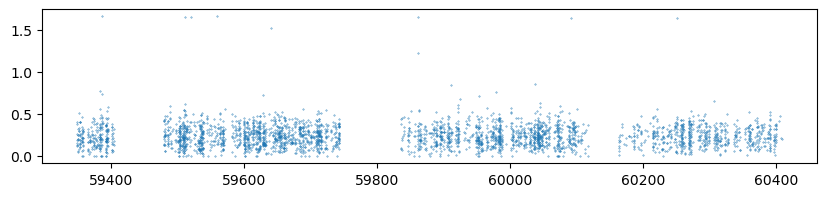

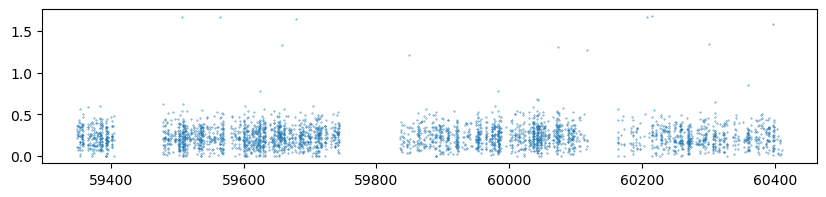

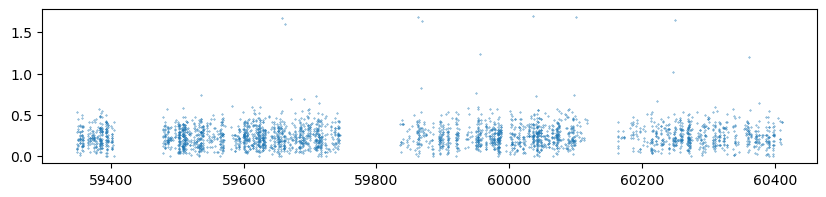

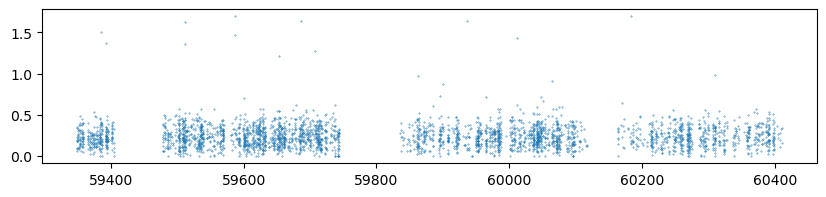

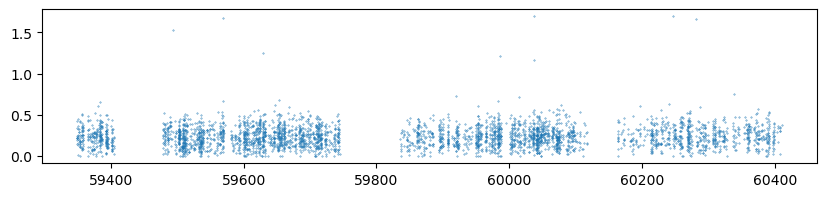

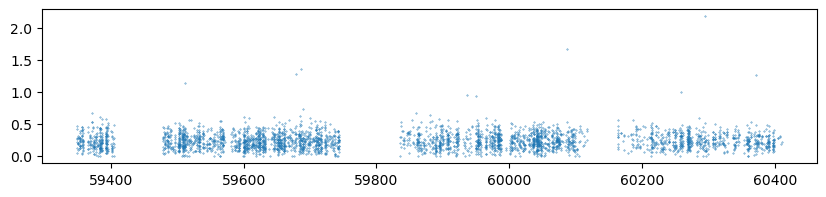

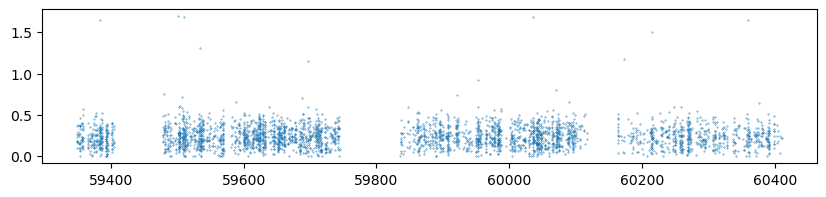

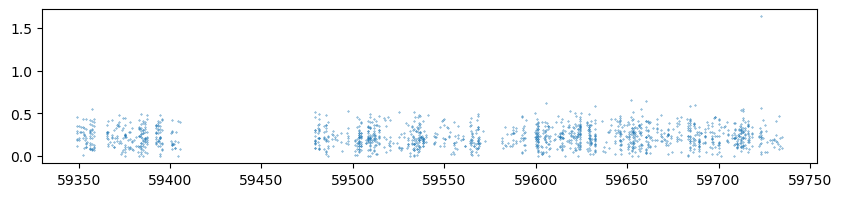

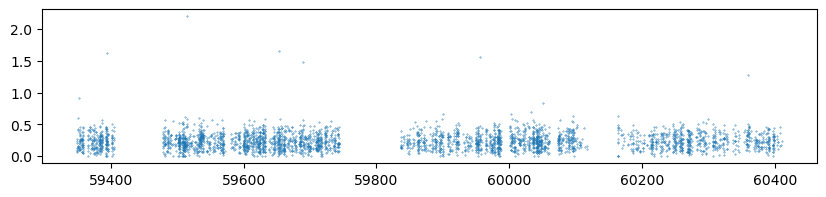

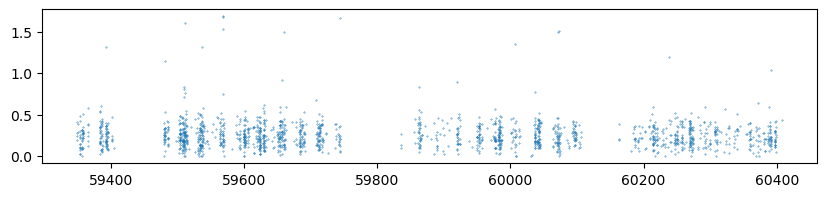

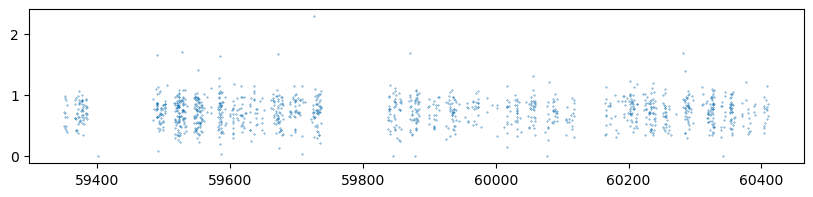

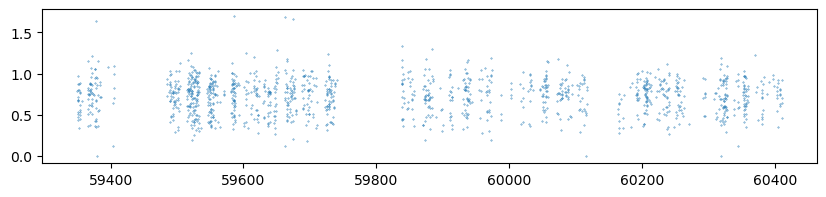

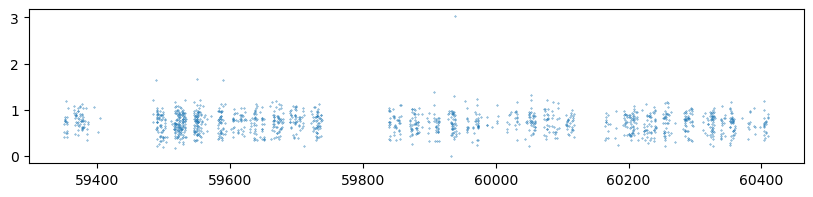

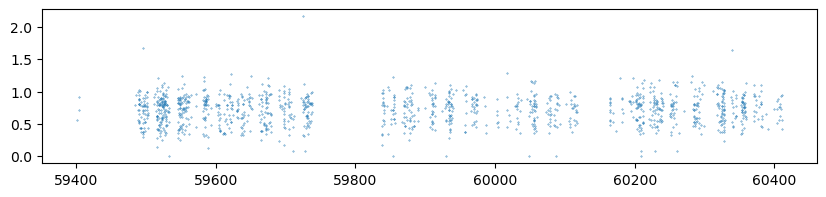

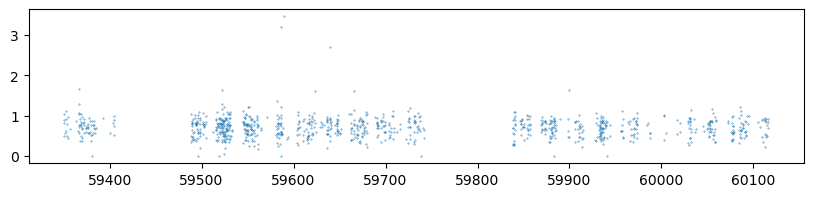

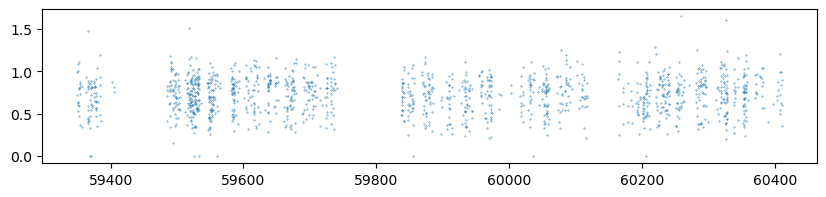

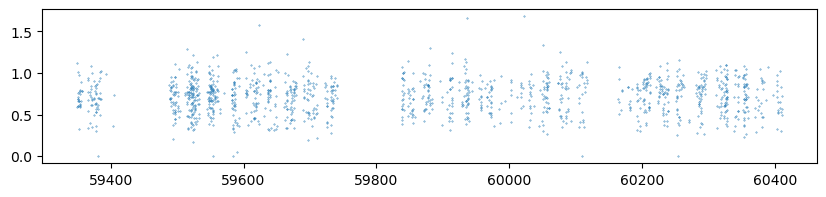

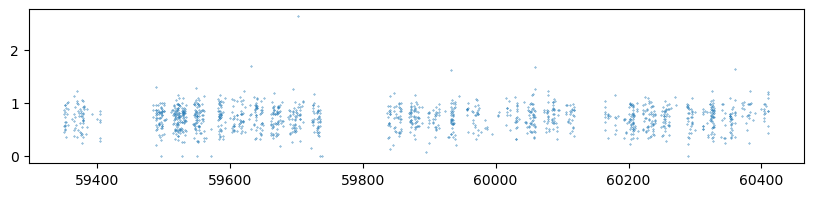

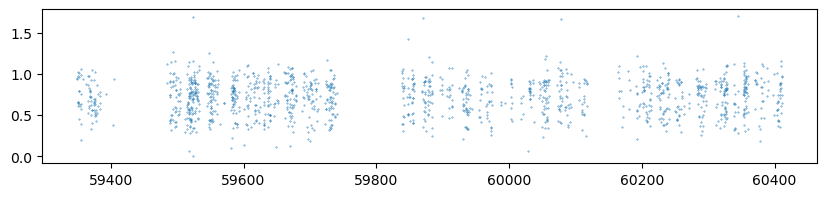

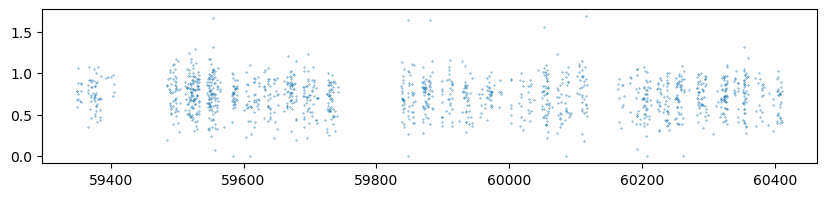

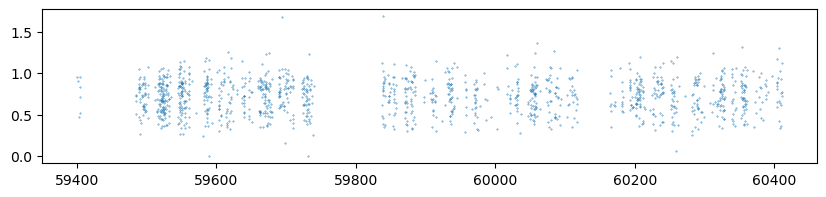

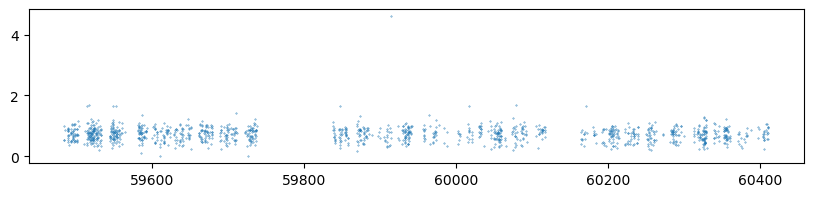

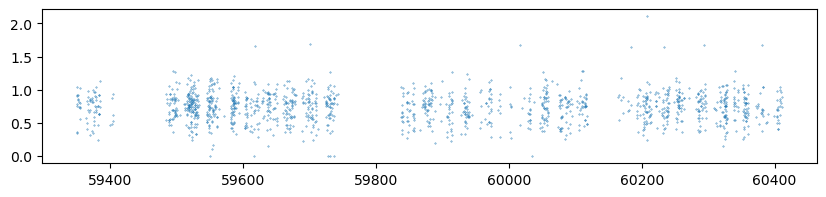

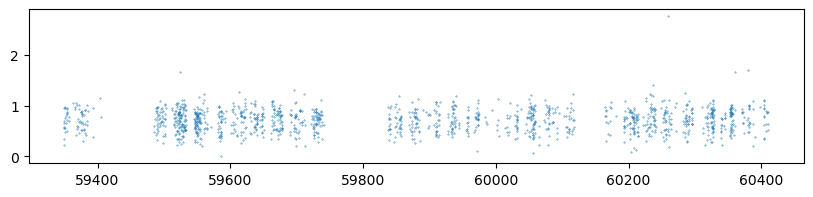

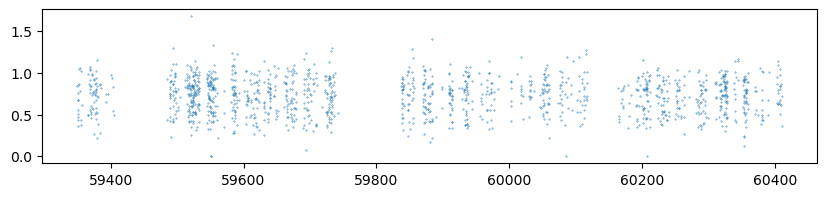

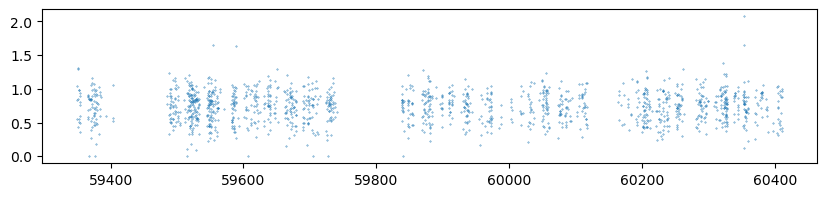

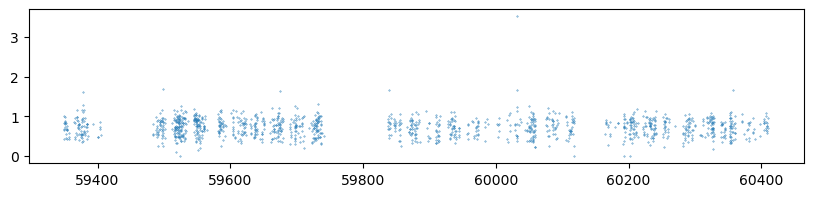

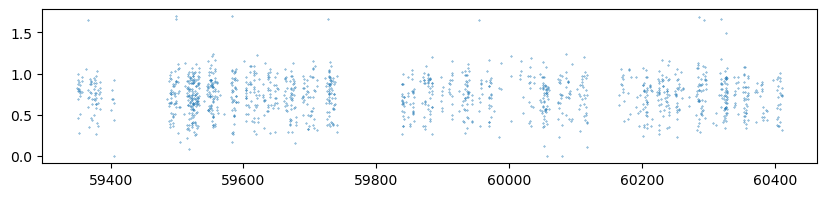

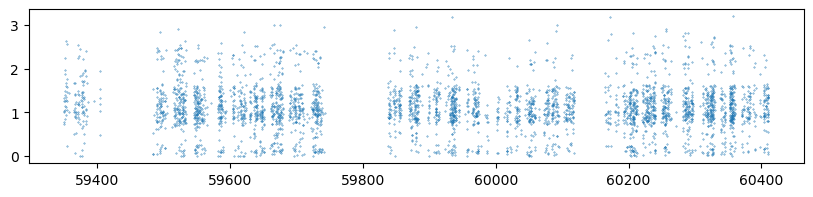

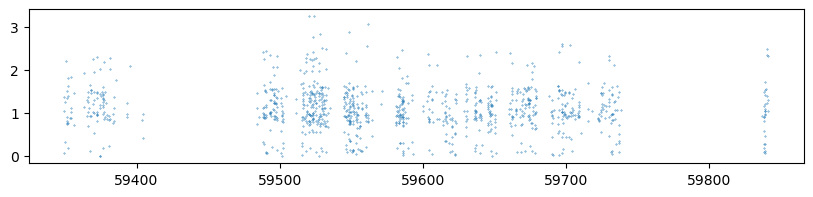

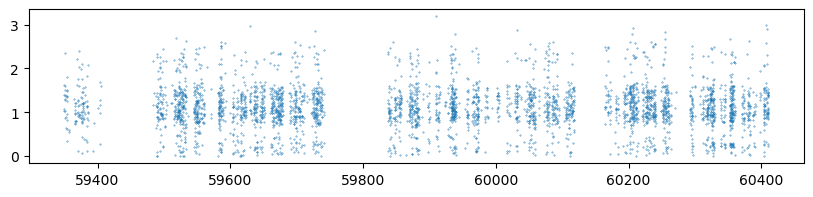

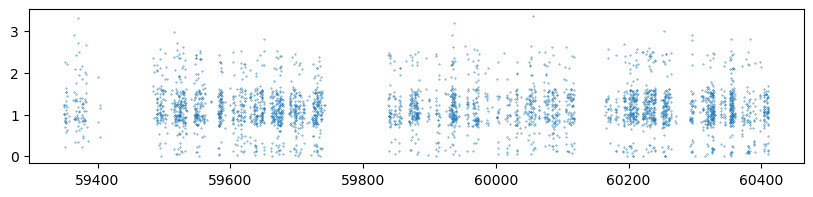

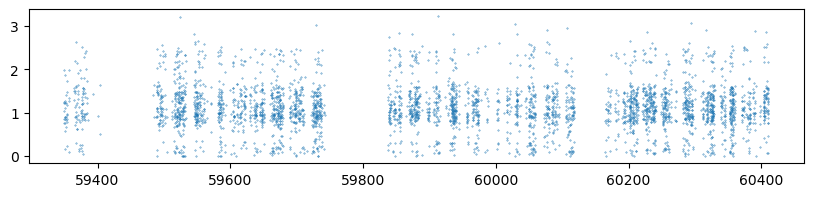

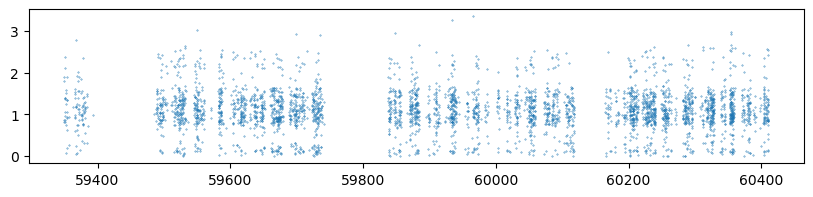

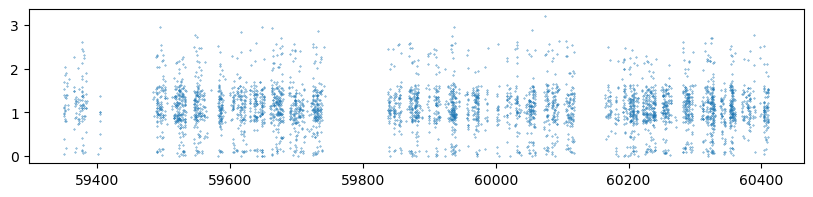

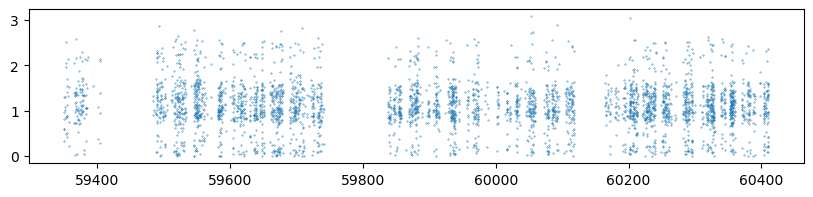

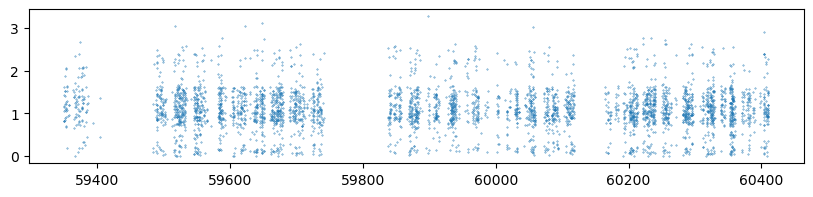

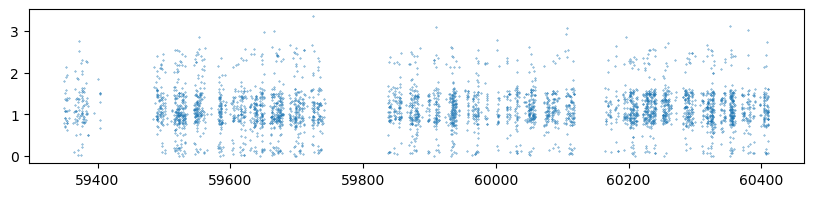

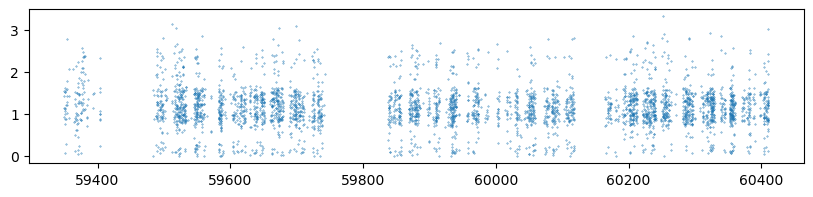

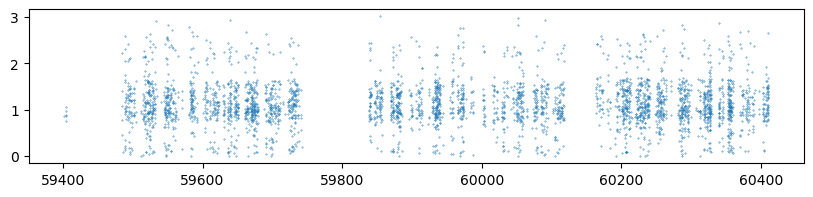

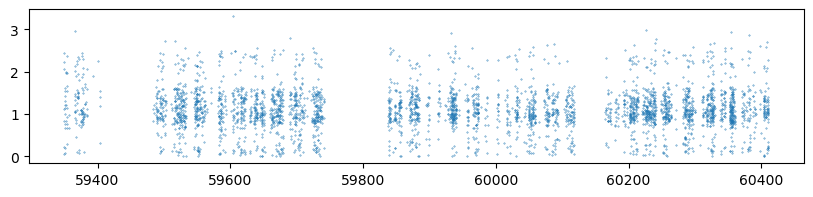

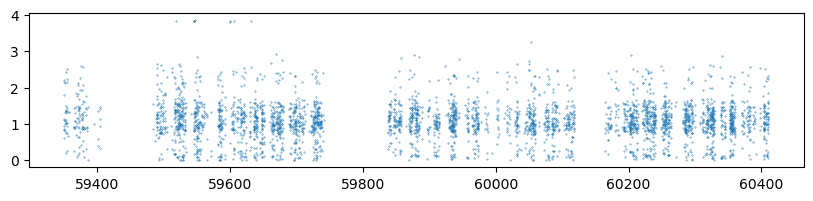

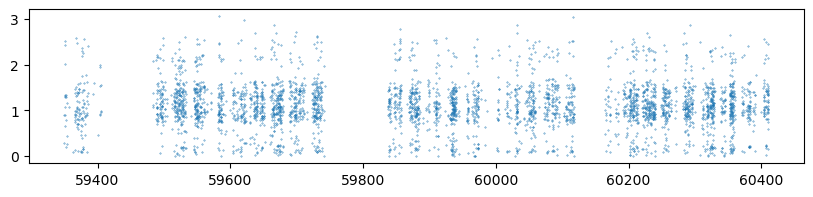

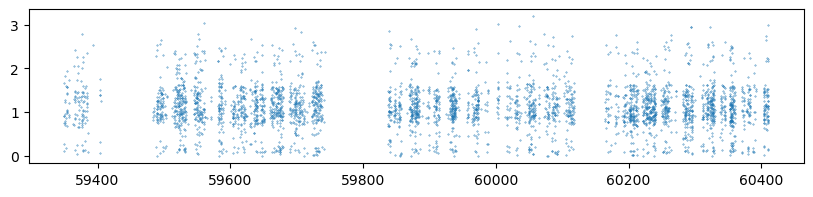

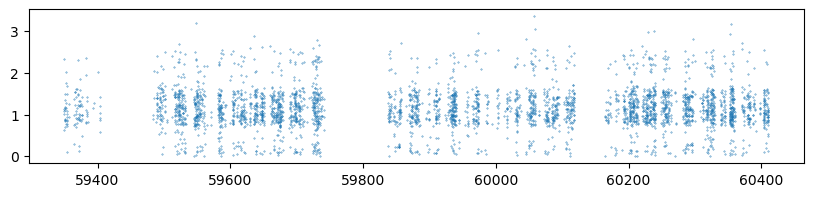

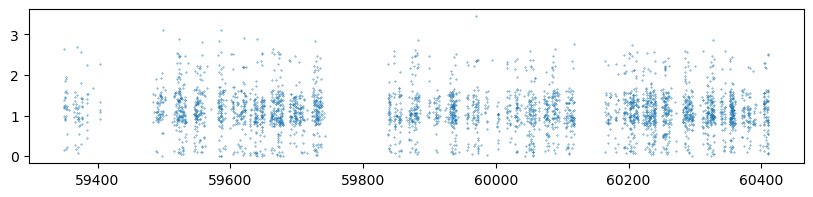

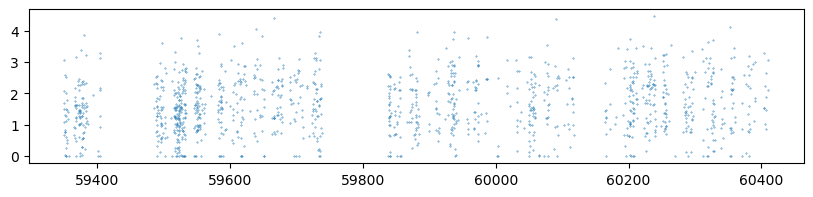

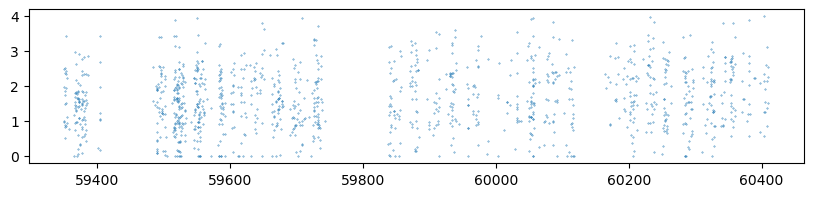

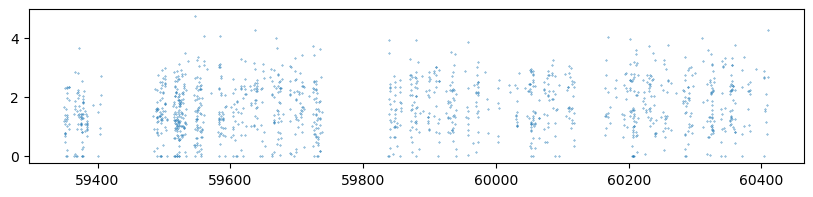

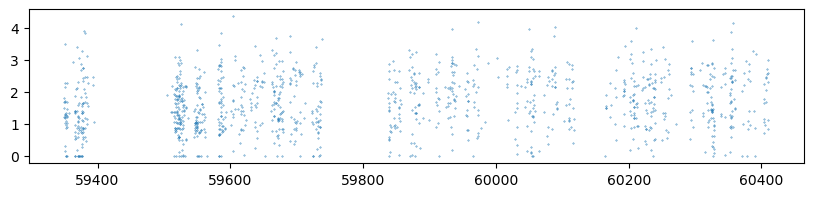

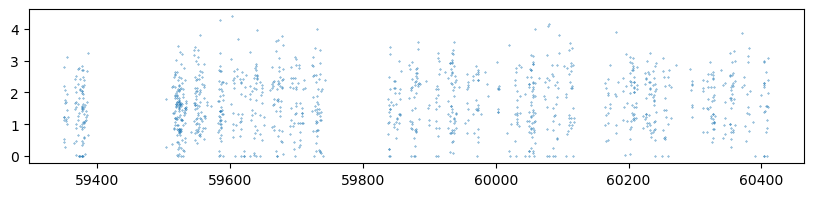

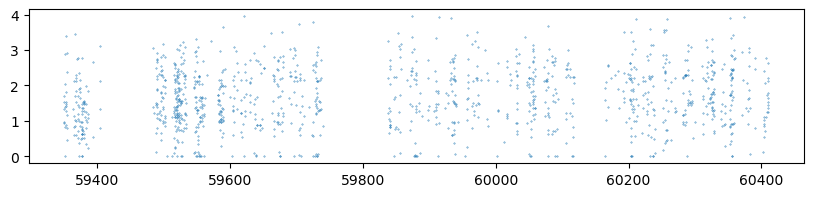

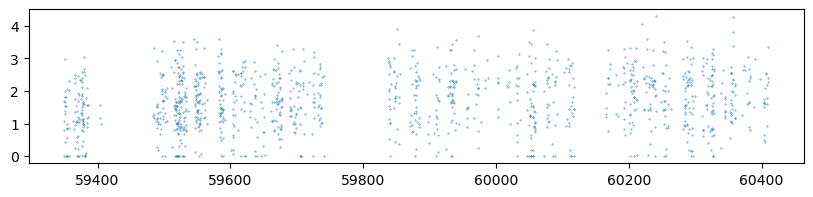

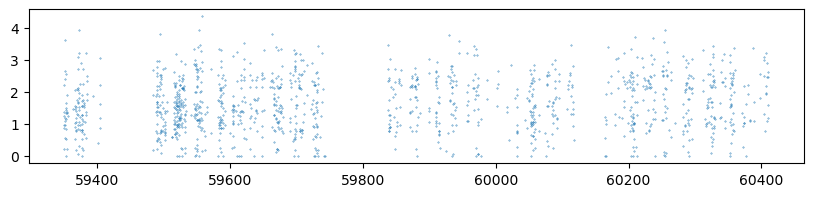

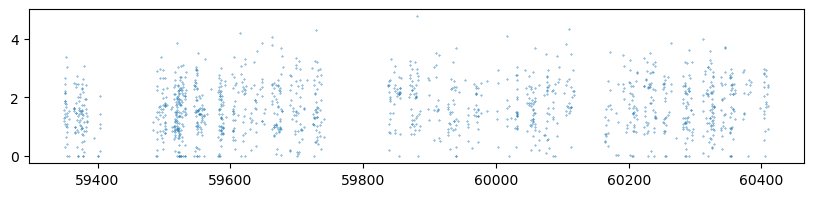

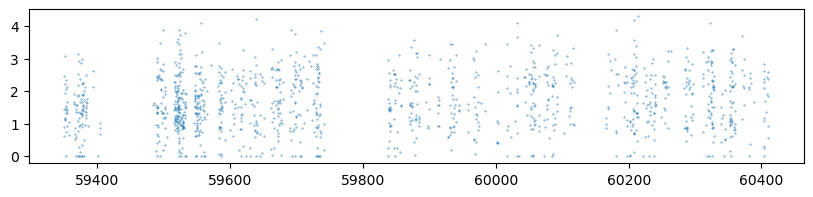

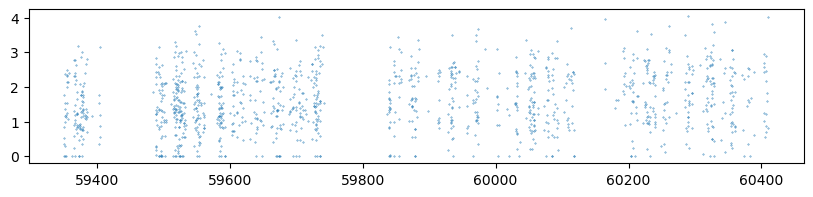

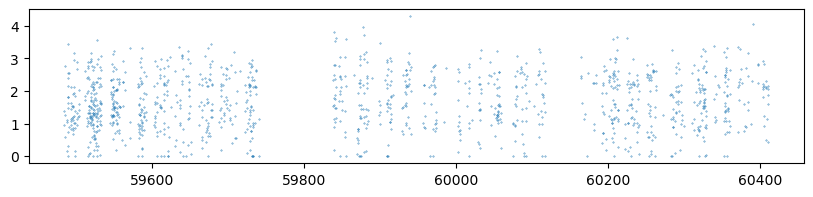

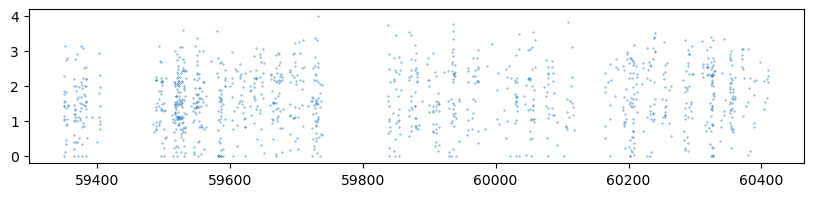

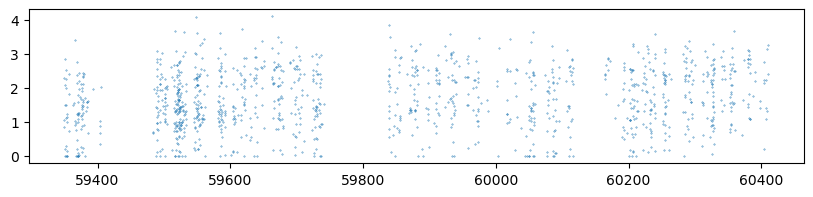

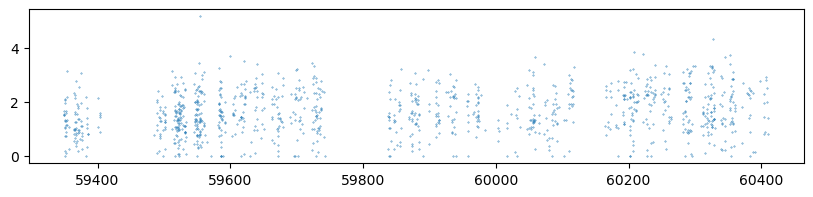

In [36]:
fiber_data_sets = [bgs_cat_fibers, lrg_cat_fibers, elg_cat_fibers, qso_cat_fibers]

for i, (data, label) in enumerate(zip(data_sets, labels)):
    ll = data['entropy']<-5
    outlier_fibers = data['fibers'][ll]
    for j in outlier_fibers:
        plt.figure(figsize=(10,1))
        plt.scatter(fiber_data_sets[i][j]['MIN_MJD'], fiber_data_sets[i][j]['Z'], s=0.1)
        plt.show()

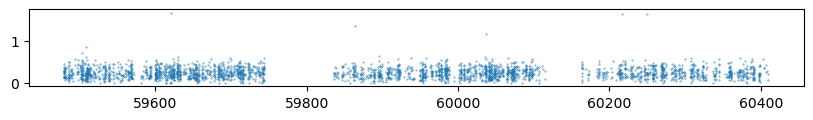

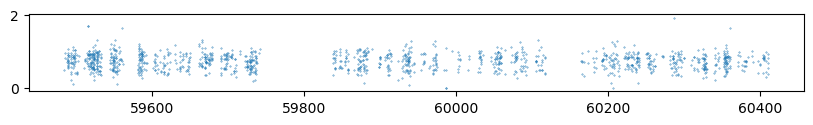

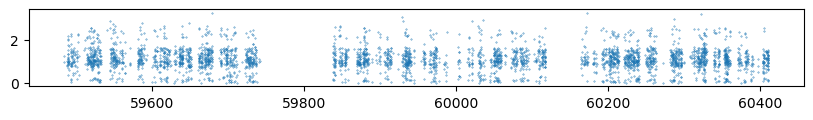

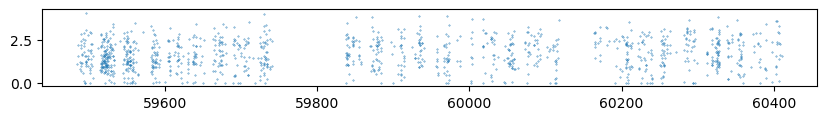

In [38]:
fiber_data_sets = [bgs_cat_fibers, lrg_cat_fibers, elg_cat_fibers, qso_cat_fibers]

for i, (data, label) in enumerate(zip(data_sets, labels)):
    ll = data['entropy']<-5
    outlier_fibers = [3070]
    for j in outlier_fibers:
        plt.figure(figsize=(10,1))
        plt.scatter(fiber_data_sets[i][j]['MIN_MJD'], fiber_data_sets[i][j]['Z'], s=0.1)
        plt.show()

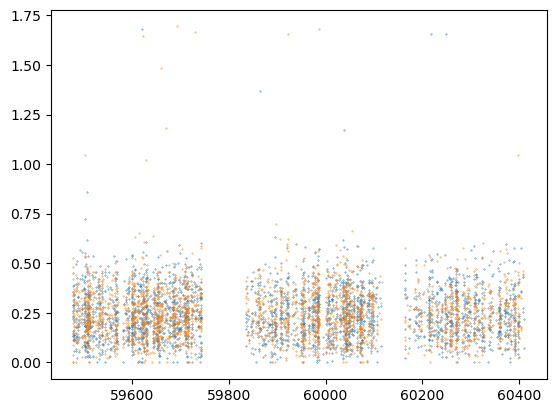

In [40]:
j = 3070
i = 0
plt.scatter(fiber_data_sets[i][j]['MIN_MJD'], fiber_data_sets[i][j]['Z'], s=0.1)

